# READ ME ❗❗

Some advices on implementing new model ◀

> 1. This is designed for image based classification/ bounding box Models, if you want to try other models, can take the reference on the full pipeline of this.


> 2. If you keep encountering build errors (package compatibility, outdated dependencies) when implementing a new model, its often not worth the effort. Another model (DefNet from GitHub) took me 1-2 days to build and still had errors, leading to even more issues. In contrast, I implemented this PyTorch model from scratch to training in just 4-5 hours.

Things to take note in this model ✅

> 1. Pay attention to dataset annotations, as they impact data augmentation and preprocessing. Since our dataset uses bounding boxes, resizing from 400x700 to 224x224 requires scaling the bounding box coordinates accordingly. Otherwise, training on 224x224 images with unscaled coordinates (e.g., 312, 512, 377, 600) would be illogical. Could refer Some parts in Class CustomCoCODataset & Class BboxAugmentation . **torchvision.transforms library (we learnt in class) only do image transforms but not bbox.**



> 2.  In Class **load_data** ,I computed the mean and standard deviation for dataset normalization instead of using the predefined normalization values from a pretrained model's dataset.( Which can be found on internet) because we want to make our model customized to the dataset.






In [1]:
########## This section is designed to be modified according to needs#########




########## This section is designed to be modified according to needs#########

# Load Dataset Into your notebook

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HEIVkitsKN5GrtOiJhcI")
project = rf.workspace("five-defects").project("yes_defects")
version = project.version(4)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yes_defects-4 in coco:: 100%|██████████| 5065/5065 [00:00<00:00, 6383.60it/s]


# 1. Import dataset from Roboflow where we can just straight download code snippet and integrate

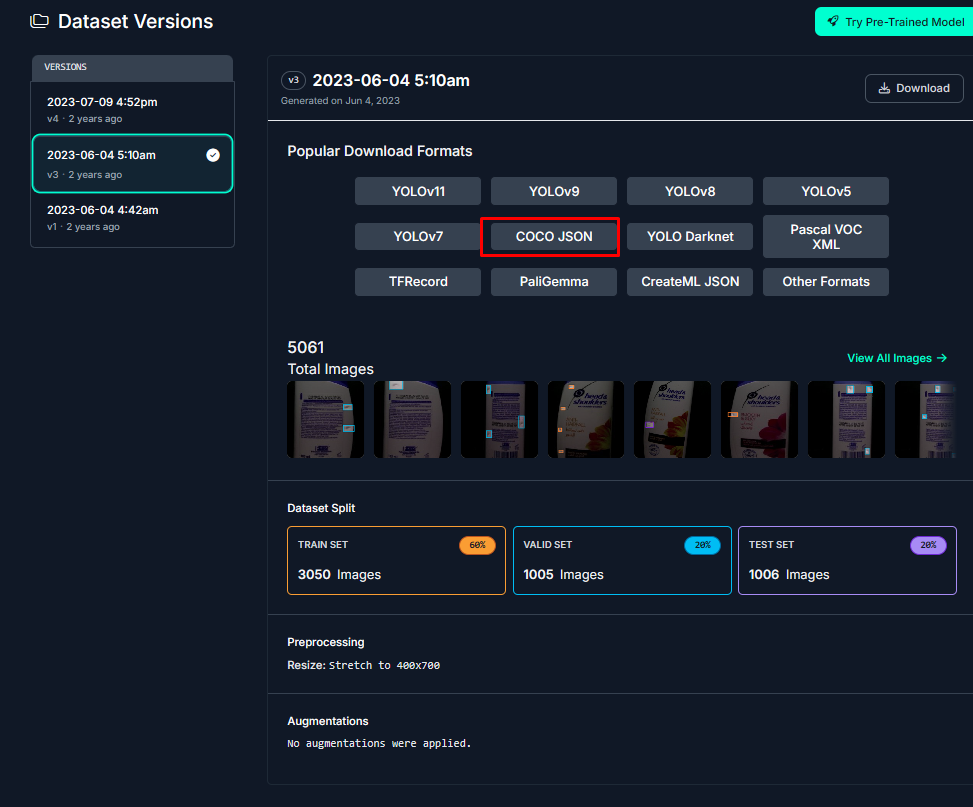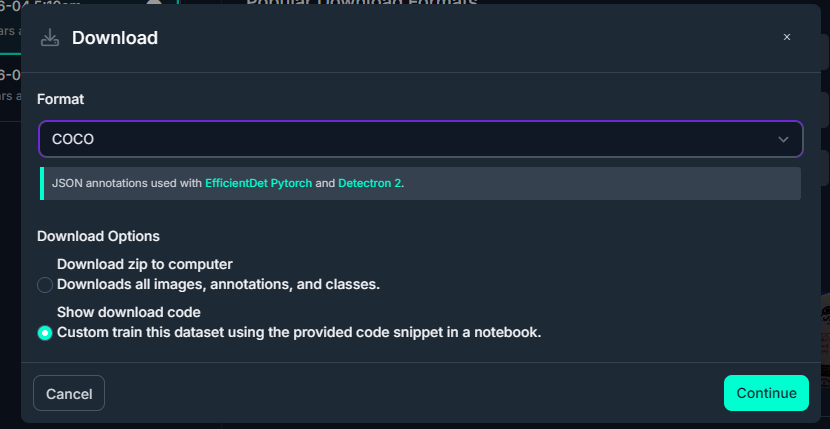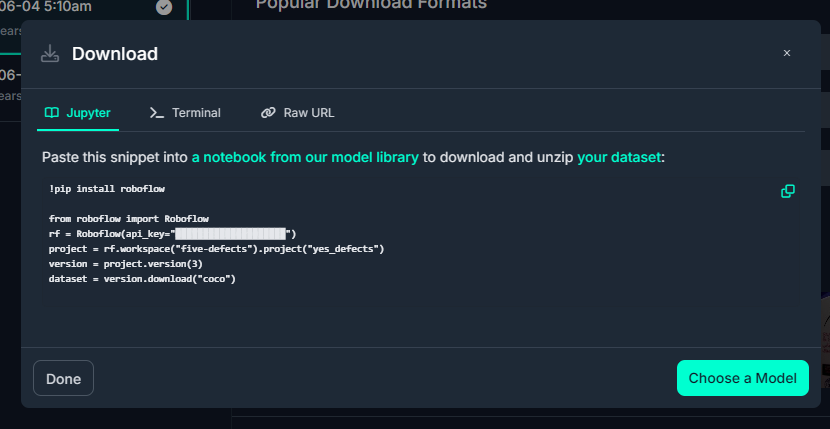

# 2. Setting Up Dataset

## 2.1 Defining Dataset Class (Resizing, Reduce Ratio)

In [3]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os
import random
import numpy as np
from PIL import Image, ImageFilter

class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None, img_size=None, reduce_ratio=None):
        """
        Args:
            root (str): Path to the image directory.
            annotation_file (str): Path to the COCO JSON annotation file.
            transforms (callable, optional): Transformations applied to images.
            img_size (tuple, optional): Target image size (width, height).
            reduce_ratio (float, optional): Ratio to reduce the dataset. If None, no reduction.
        """

        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.img_size = img_size  # (width, height), or None for no resizing

        # Reduce dataset by ratio if specified
        if reduce_ratio:
            self.reduce_dataset(reduce_ratio)

    def reduce_dataset(self, ratio):
        """
        Reduces the dataset size by the specified ratio.
        Args:
            ratio (float): Ratio to reduce the dataset, e.g., 0.5 means keep half the data.
        """
        num_samples = len(self.ids)
        num_samples_to_keep = int(num_samples * ratio)
        self.ids = random.sample(self.ids, num_samples_to_keep)
        print(f"Reduced dataset to {num_samples_to_keep} samples (from {num_samples}).")


    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")


        # Original image size
        orig_w, orig_h = img_info["width"], img_info["height"]

        # Resize image if needed
        if self.img_size:
            new_w, new_h = self.img_size
            image = F.resize(image, (new_h, new_w))
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            scale_x, scale_y = 1.0, 1.0

        if self.transforms:
            image = self.transforms(image)


        # Scale bounding boxes accordingly
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            xmin = x * scale_x
            ymin = y * scale_y
            xmax = (x + w) * scale_x
            ymax = (y + h) * scale_y

            # Ensure valid bounding boxes
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(ann["category_id"])
            else:
                print(f"Warning: Invalid bbox {xmin, ymin, xmax, ymax} removed.")

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}
        return image, target

    def __len__(self):
        return len(self.ids)


## 2.2 Extract Class Name From the annotations.coco.json (DEFINE CLASS NAME)

In [4]:
import json

# Load your annotation file
#################CHANGE TO YOUR PATH#######################################

with open('/content/yes_defects-4/train/_annotations.coco.json') as f:

#################CHANGE TO YOUR PATH#######################################

    data = json.load(f)

# Extract class names (sorted by category_id)
CLASS_NAMES = [
    category['name'] for category in sorted(data['categories'], key=lambda x: x['id'])
    if category['id'] != 0  # Exclude category with ID 0
]
CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx + 1: cls_name for idx, cls_name in enumerate(CLASS_NAMES)}  # Reverse mapping

print(CLASS_NAMES)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Index to Class Mapping:", IDX_TO_CLASS)

['M_adhesion', 'POB_marginal', 'POB_unacceptable', 'U_adhesion', 'dent_marginal', 'dent_unacceptable', 'scuff_marginal', 'scuff_unacceptable']
Class to Index Mapping: {'M_adhesion': 1, 'POB_marginal': 2, 'POB_unacceptable': 3, 'U_adhesion': 4, 'dent_marginal': 5, 'dent_unacceptable': 6, 'scuff_marginal': 7, 'scuff_unacceptable': 8}
Index to Class Mapping: {1: 'M_adhesion', 2: 'POB_marginal', 3: 'POB_unacceptable', 4: 'U_adhesion', 5: 'dent_marginal', 6: 'dent_unacceptable', 7: 'scuff_marginal', 8: 'scuff_unacceptable'}


## 2.3 Checking Dataset Distribution.

In [5]:
def analyze_class_distribution(dataset, dataset_name="Dataset"):
    """Analyze and print class distribution statistics"""
    class_counts = {name: 0 for name in CLASS_NAMES}

    # Count instances per class
    for _, target in dataset:
        for label in target['labels']:
            class_name = IDX_TO_CLASS[label.item()]
            class_counts[class_name] += 1

    # Calculate statistics
    total_samples = sum(class_counts.values())
    print(f"\n=== {dataset_name} Class Distribution ===")
    print(f"{'Class':<20} {'Count':>10} {'Percentage':>12}")

    for name, count in class_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{name:<20} {count:>10} {percentage:>10.2f}%")

    # Calculate imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')


### 2.3.1 For non split dataset (Run either one According to your Dataset Nature, Pre split or non split. DO NOT RUN BOTH)

In [6]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm

##############CHANG TO YOUR PATH#################

root_dir = "/content/yes_defects-4"

##############CHANG TO YOUR PATH#################

train_dir = os.path.join(root_dir, "train")
train_json = os.path.join(train_dir, "_annotations.coco.json")

AllData_dataset = CustomCocoDataset(
    root=train_dir,
    annotation_file=train_json,
    transforms=T.ToTensor(),  # Only this transform
    img_size=None,  # Don't resize yet
    reduce_ratio=None
)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [7]:
analyze_class_distribution(AllData_dataset, "AllData")


=== AllData Class Distribution ===
Class                     Count   Percentage
M_adhesion                  630       4.37%
POB_marginal               2140      14.85%
POB_unacceptable           2190      15.20%
U_adhesion                 1196       8.30%
dent_marginal              2645      18.36%
dent_unacceptable          2239      15.54%
scuff_marginal             1474      10.23%
scuff_unacceptable         1896      13.16%


### 2.3.2  For pre split dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm

##############CHANG TO YOUR PATH#################

root_dir = "/content/yes_defects-4"

##############CHANG TO YOUR PATH#################

train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")
test_dir = os.path.join(root_dir, "test")

train_json = os.path.join(train_dir, "_annotations.coco.json")
valid_json = os.path.join(valid_dir, "_annotations.coco.json")
test_json = os.path.join(test_dir, "_annotations.coco.json")

train_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=T.ToTensor(),
            img_size=(224, 224),
            reduce_ratio=None
        )

valid_dataset = CustomCocoDataset(
            root=valid_dir,
            annotation_file=valid_json,
            transforms=T.ToTensor(),
            img_size=(224, 224),
            reduce_ratio=None
    )

test_dataset = CustomCocoDataset(
            root=test_dir,
            annotation_file=test_json,
            transforms=T.ToTensor(),
            img_size=(224, 224),
            reduce_ratio=None
    )

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
analyze_class_distribution(train_dataset, "Training Set")
analyze_class_distribution(valid_dataset, "Validation Set")
analyze_class_distribution(test_dataset, "Test Set")

NameError: name 'train_dataset' is not defined

## 2.4 Data spliting (Perform This on Non Split Dataset)

In [9]:
import filecmp
import shutil
import os
from collections import defaultdict
from torch.utils.data import Dataset, Subset

def create_balanced_splits_and_dirs(dataset, root_dir, test_size=0.10, val_size=0.10, random_seed=42):
    """
    Creates balanced train/val/test splits and corresponding directories with COCO JSON files
    """
    # Create new directory structure
    new_dirs = {
        'train': os.path.join(root_dir, "train"),
        'valid': os.path.join(root_dir, "valid"),
        'test': os.path.join(root_dir, "test")
    }

    # Create directories if they don't exist
    for dir_path in new_dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    # Group indices by class (same as before)
    class_indices = defaultdict(list)
    for idx in range(len(dataset)):
        _, target = dataset[idx]
        for label in target['labels']:
            class_indices[label.item()].append(idx)

    # Remove duplicates
    for cls in class_indices:
        class_indices[cls] = list(set(class_indices[cls]))

    # Initialize empty splits
    split_indices = {
        'train': [],
        'valid': [],
        'test': []
    }

    # Split each class separately (same as before)
    for cls, indices in class_indices.items():
        np.random.seed(random_seed)
        np.random.shuffle(indices)

        n_total = len(indices)
        n_test = int(n_total * test_size)
        n_val = int(n_total * val_size)

        n_test = max(1, n_test)
        n_val = max(1, n_val)
        n_train = max(1, n_total - n_test - n_val)

        split_indices['test'].extend(indices[:n_test])
        split_indices['valid'].extend(indices[n_test:n_test+n_val])
        split_indices['train'].extend(indices[n_test+n_val:])

    # Remove duplicates
    split_indices['train'] = list(set(split_indices['train']))
    split_indices['valid'] = list(set(split_indices['valid']) - set(split_indices['train']))
    split_indices['test'] = list(set(split_indices['test']) - set(split_indices['train']) - set(split_indices['valid']))

    # Create COCO JSON structure
    coco_template = {
        "info": dataset.coco.dataset["info"],
        "licenses": dataset.coco.dataset["licenses"],
        "categories": dataset.coco.dataset["categories"]
    }

    # Process each split with error handling
    for split_name in ['train', 'valid', 'test']:
        img_ids = set()
        anns = []

        for idx in split_indices[split_name]:
            img_info = dataset.coco.loadImgs(dataset.ids[idx])[0]
            img_ids.add(img_info['id'])
            ann_ids = dataset.coco.getAnnIds(imgIds=img_info['id'])
            anns.extend(dataset.coco.loadAnns(ann_ids))

        # Build new COCO JSON
        new_coco = coco_template.copy()
        new_coco["images"] = [img for img in dataset.coco.dataset["images"] if img['id'] in img_ids]
        new_coco["annotations"] = anns

        # Save JSON file
        json_path = os.path.join(new_dirs[split_name], "_annotations.coco.json")
        with open(json_path, 'w') as f:
            json.dump(new_coco, f)

        # Copy images with duplicate handling
        for img_info in new_coco["images"]:
            src_path = os.path.join(dataset.root, img_info['file_name'])
            dst_path = os.path.join(new_dirs[split_name], img_info['file_name'])

            if not os.path.exists(dst_path):  # Only copy if doesn't exist
                shutil.copy2(src_path, dst_path)
            elif not filecmp.cmp(src_path, dst_path):  # If exists but different
                os.remove(dst_path)
                shutil.copy2(src_path, dst_path)

    # Create PyTorch subsets
    train_dataset = Subset(dataset, split_indices['train'])
    val_dataset = Subset(dataset, split_indices['valid'])
    test_dataset = Subset(dataset, split_indices['test'])

    return train_dataset, val_dataset, test_dataset

In [10]:
# 2. Create balanced splits
train_datasetcheck, valid_datasetcheck, test_datasetcheck = create_balanced_splits_and_dirs(
    AllData_dataset,
    root_dir,
    test_size=0.10,
    val_size=0.10
)

In [11]:
analyze_class_distribution(train_datasetcheck, "Training Set")
analyze_class_distribution(valid_datasetcheck, "Validation Set")
analyze_class_distribution(test_datasetcheck, "Test Set")


=== Training Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                  508       4.40%
POB_marginal               1722      14.93%
POB_unacceptable           1732      15.01%
U_adhesion                  955       8.28%
dent_marginal              2110      18.29%
dent_unacceptable          1800      15.60%
scuff_marginal             1196      10.37%
scuff_unacceptable         1513      13.12%

=== Validation Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                   63       4.50%
POB_marginal                191      13.64%
POB_unacceptable            228      16.29%
U_adhesion                  120       8.57%
dent_marginal               251      17.93%
dent_unacceptable           225      16.07%
scuff_marginal              135       9.64%
scuff_unacceptable          187      13.36%

=== Test Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                   59       4.

## 2.5 Defining Classes and functions

### 2.5.1 Defining Data Augmentation Class

In [30]:
class BboxAugmentation:
    def __init__(self,
                 flip_prob=0.5,
                 max_shift=0.1,
                 max_rotate=15,
                 brightness=None,
                 contrast=None):
        self.flip_prob = flip_prob
        self.max_shift = max_shift  # Fraction of image size
        self.max_rotate = max_rotate  # Degrees
        self.brightness = brightness
        self.contrast = contrast
        self._is_tensor = False  # Track if input is tensor

    def __call__(self, image, target):
        # Track if input is tensor
        self._is_tensor = isinstance(image, torch.Tensor)

        # Convert tensor to PIL if needed
        if self._is_tensor:
            image = F.to_pil_image(image)

        # Get image dimensions
        w, h = image.size

        # Apply augmentations in sequence
        if random.random() < self.flip_prob:
            image, target = self.horizontal_flip(image, target)

        if random.random() < 0.5:
            shift_x = random.uniform(-self.max_shift, self.max_shift) * w
            shift_y = random.uniform(-self.max_shift, self.max_shift) * h
            image, target = self.shift(image, target, shift_x, shift_y)

        if random.random() < 0.5:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            image, target = self.rotate(image, target, angle)

        # Convert back to tensor if original was tensor
        if self._is_tensor:
            image = F.to_tensor(image)

        return image, target

    def horizontal_flip(self, image, target):
        image = F.hflip(image)
        w = image.width

        # Flip bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # x1 = w - x2, x2 = w - x1
        target["boxes"] = boxes

        return image, target

    def shift(self, image, target, shift_x, shift_y):
        # Apply affine transformation
        image = F.affine(
            image,
            angle=0,
            translate=(int(shift_x), int(shift_y)),
            scale=1.0,
            shear=0
        )

        # Shift bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] += shift_x  # x coordinates
        boxes[:, [1, 3]] += shift_y  # y coordinates

        # Clip boxes to image boundaries
        boxes[:, 0::2].clamp_(min=0, max=image.width)
        boxes[:, 1::2].clamp_(min=0, max=image.height)

        # Remove boxes that became invalid
        valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        target["boxes"] = boxes[valid_boxes]
        target["labels"] = target["labels"][valid_boxes]

        return image, target

    def rotate(self, image, target, angle):
        """Rotates the image and bounding boxes by a given angle."""
        # Convert to tensor to get dimensions
        img_tensor = F.to_tensor(image)
        h, w = img_tensor.shape[-2:]

        # Rotate image
        image = F.rotate(image, angle, expand=False)

        # Handle bounding boxes if they exist
        if 'boxes' in target and len(target['boxes']) > 0:
            # Convert boxes to polygons, rotate, then back to boxes
            boxes = target["boxes"].clone()  # Clone to avoid modifying the original
            polygons = []
            for box in boxes:
                x1, y1, x2, y2 = box
                # Create polygon coordinates
                poly = np.array([
                    [x1, y1], [x2, y1], [x2, y2], [x1, y2]
                ])
                polygons.append(poly)

            # Rotate polygons
            center = (w / 2, h / 2)
            rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_polys = []
            for poly in polygons:
                # Add ones for homogeneous coordinates
                poly_homo = np.column_stack((poly, np.ones(4)))
                rotated_poly = np.dot(rot_mat, poly_homo.T).T
                rotated_polys.append(rotated_poly)

            # Convert back to boxes
            new_boxes = []
            for poly in rotated_polys:
                x_coords = poly[:, 0]
                y_coords = poly[:, 1]
                new_box = [
                    max(0, min(x_coords)),
                    max(0, min(y_coords)),
                    min(w, max(x_coords)),
                    min(h, max(y_coords))
                ]
                new_boxes.append(new_box)

            new_boxes = torch.tensor(new_boxes, dtype=torch.float32)

            # Filter invalid boxes (if any)
            if len(new_boxes) > 0:
                valid_boxes = (new_boxes[:, 2] > new_boxes[:, 0]) & (new_boxes[:, 3] > new_boxes[:, 1])

                # Update target if valid boxes exist after rotation
                if valid_boxes.any():
                    target["boxes"] = new_boxes[valid_boxes]
                    target["labels"] = target["labels"][valid_boxes]
                else:
                    # Handle the case where no valid boxes remain
                    print("Warning: All bounding boxes became invalid after rotation. Removing them.")
                    del target["boxes"]  # Remove 'boxes' from the target
                    del target["labels"]  # Remove 'labels' to be consistent
            else:
                print("Warning: No bounding boxes found after rotation.")

        return image, target

In [25]:
# Wrap your dataset with augmentation
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, bbox_augment, transforms=None):
        self.dataset = dataset  # Original dataset
        self.bbox_augment = bbox_augment  # Augmentation class
        self.transforms = transforms  # Optional normalization transform

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        # Apply augmentation to the image and target
        augmented_image, augmented_target = self.bbox_augment(image, target)

        # Apply normalization if a transform is provided
        if self.transforms:
            augmented_image = self.transforms(augmented_image)

        return augmented_image, augmented_target

    def __len__(self):
        return len(self.dataset)


### 2.5.2 Compute the Datasets Normalization value (mean and std for your dataset)

In [14]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm

train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")
test_dir = os.path.join(root_dir, "test")

train_json = os.path.join(train_dir, "_annotations.coco.json")
valid_json = os.path.join(valid_dir, "_annotations.coco.json")
test_json = os.path.join(test_dir, "_annotations.coco.json")

# 1. Create basic dataset with only ToTensor transform
temp_dataset = CustomCocoDataset(
    root=train_dir,
    annotation_file=train_json,
    transforms=T.ToTensor(),  # Only this transform
    img_size=None,  # Don't resize yet
    reduce_ratio=None
)

# 2. Compute stats directly
pixel_sum = torch.zeros(3)
pixel_sq_sum = torch.zeros(3)
num_pixels = 0

for img, _ in temp_dataset:  # Direct iteration (no DataLoader)
    pixel_sum += img.sum(dim=[1, 2])  # Sum over height and width
    pixel_sq_sum += (img**2).sum(dim=[1, 2])
    num_pixels += img.shape[1] * img.shape[2]

Calculatedmean = pixel_sum / num_pixels
Calculatedstd = (pixel_sq_sum / num_pixels - Calculatedmean**2).sqrt()

print(f"Mean: {Calculatedmean.tolist()}")
print(f"Std: {Calculatedstd.tolist()}")

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Mean: [0.19236160814762115, 0.17719830572605133, 0.20118412375450134]
Std: [0.23881150782108307, 0.2204182893037796, 0.2409134805202484]


### 2.5.3 Data loader function (with data augmentation)

In [31]:
batch_size=16
num_workers=2
pin_memory=True
collate_fn=lambda x: tuple(zip(*x))


# Now define actual transforms with computed values
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=Calculatedmean, std=Calculatedstd)
])

def load_data(data_augmentation=False):

    if data_augmentation: #When data_augmentation is true
        original_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

        ##############Change the reduce ratio to control the amount of augmented data according to your needs. #########################
        Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5 ### which means reduce the input dataset by half
        )
        ##############Change the reduce ratio to control the amount of augmented data according to your needs.#########################

        # Create augmentation instance
        bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

        augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

        #merging Two datasets
        train_dataset = torch.utils.data.ConcatDataset([original_dataset,augmented_dataset])

    else: #when Data augmentation is False
        train_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

    valid_dataset = CustomCocoDataset(
            root=valid_dir,
            annotation_file=valid_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    test_dataset = CustomCocoDataset(
            root=test_dir,
            annotation_file=test_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    #Put them into Data loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    return train_dataset , valid_dataset, test_dataset, train_loader, valid_loader , test_loader


**Without Augmentation**

In [16]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = load_data(data_augmentation=False)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images in training set: 3109
Number of images in validation set: 385
Number of images in test set: 385


**With Augmentation**

In [32]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader= load_data(data_augmentation=True)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Reduced dataset to 1554 samples (from 3109).
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images in training set: 4663
Number of images in validation set: 385
Number of images in test set: 385


**Last check on data distribution to prevent Data Imbalance Problem**


In [18]:
import cv2

analyze_class_distribution(train_dataset, "Training Set")
analyze_class_distribution(valid_dataset, "Validation Set")
analyze_class_distribution(test_dataset, "Test Set")


=== Training Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                  763       4.42%
POB_marginal               2579      14.94%
POB_unacceptable           2587      14.99%
U_adhesion                 1419       8.22%
dent_marginal              3161      18.31%
dent_unacceptable          2705      15.67%
scuff_marginal             1783      10.33%
scuff_unacceptable         2266      13.13%

=== Validation Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                   63       4.50%
POB_marginal                191      13.64%
POB_unacceptable            228      16.29%
U_adhesion                  120       8.57%
dent_marginal               251      17.93%
dent_unacceptable           225      16.07%
scuff_marginal              135       9.64%
scuff_unacceptable          187      13.36%

=== Test Set Class Distribution ===
Class                     Count   Percentage
M_adhesion                   59       4.

## 2.6 Visualization with the annotated BBox ( checking augmented image is aligned with it's bbox)

**Augmented visualization**

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Reduced dataset to 1554 samples (from 3109).


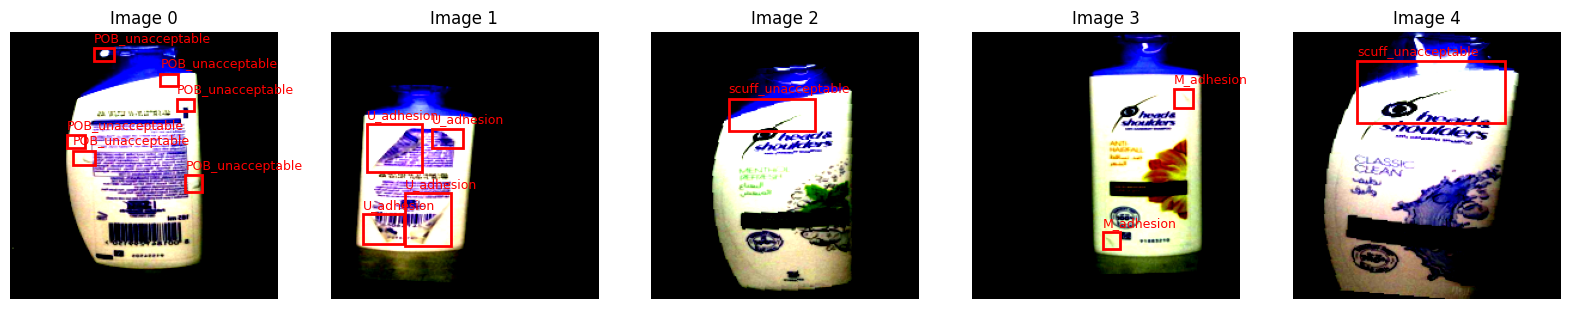

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image
import cv2

Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5
        )

        # Create augmentation instance
bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()


# Visualize images from the training dataset
visualize_batch(augmented_dataset)


**Train Data set (with Augmented data)**

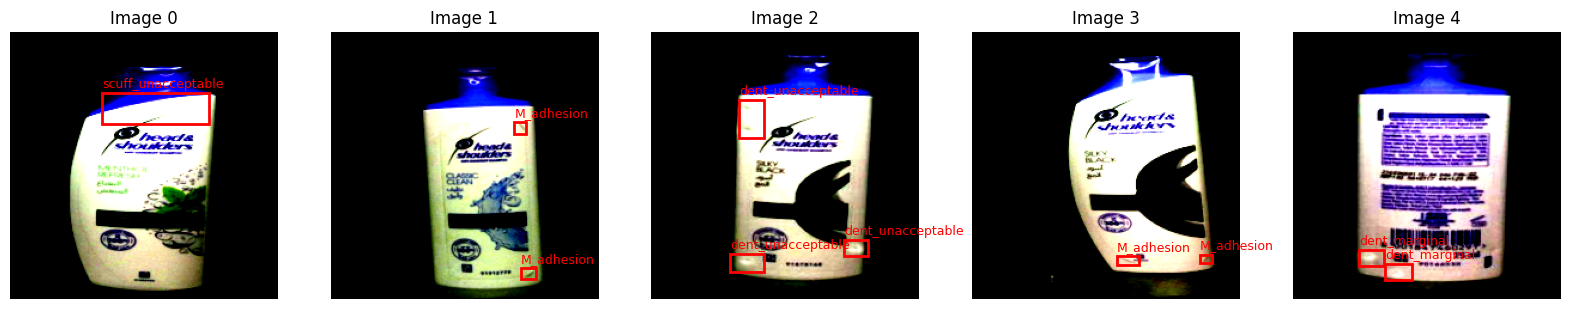

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image



# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()

# Visualize images from the training dataset
visualize_batch(train_dataset)


# 3. Model Training

## 3.1 Setting up the model and start Training

In [34]:
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque


# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(CLASS_NAMES) + 1  # Number of classes + 1 for background
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with loss visualization
num_epochs = 8
train_losses = []
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**This function detects early training anomalies and stops the process to prevent wasting time on a faulty model.**

In [22]:
def train_with_anomaly_detection(model, train_loader, optimizer, device, num_epochs=10):
    train_losses = []
    early_stop = False
    anomaly_threshold = 5.0  # Threshold for initial loss anomaly
    patience = 3  # Number of epochs to wait before stopping
    min_valid_boxes = 1  # Minimum number of valid boxes required

    # For tracking recent losses
    recent_losses = deque(maxlen=patience)

    for epoch in range(num_epochs):
        if early_stop:
            print("Training stopped early due to abnormal loss patterns.")
            break

        running_loss = 0.0
        batch_count = 0
        skipped_batches = 0

        for i, (images, targets) in enumerate(train_loader):
            # Filter out images with empty bounding boxes
            valid_images = []
            valid_targets = []

            for img, target in zip(images, targets):
                # Check if target has boxes and they're valid
                if 'boxes' in target and len(target['boxes']) >= min_valid_boxes:
                    # Convert to tensor if needed
                    if not isinstance(target['boxes'], torch.Tensor):
                        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
                    # Check box dimensions (x1,y1,x2,y2)
                    if target['boxes'].shape[-1] == 4:
                        valid_images.append(img)
                        valid_targets.append(target)

            # Skip batch if no valid images
            if len(valid_images) == 0:
                skipped_batches += 1
                print(f"Batch {i+1} skipped - no valid bounding boxes")
                continue

            # Move valid data to device
            valid_images = [img.to(device) for img in valid_images]
            valid_targets = [{k: v.to(device) for k, v in t.items()} for t in valid_targets]

            # Training step
            optimizer.zero_grad()
            try:
                loss_dict = model(valid_images, valid_targets)
                loss = sum(loss for loss in loss_dict.values())
                loss.backward()
                optimizer.step()

                current_loss = loss.item()
                running_loss += current_loss
                batch_count += 1

                # Early batch-level anomaly detection (first 5 valid batches)
                if batch_count < 5 and current_loss > anomaly_threshold:
                    print(f"Abnormal initial loss detected: {current_loss:.4f} (threshold: {anomaly_threshold})")
                    print("Possible issues: incorrect data normalization, model initialization, or learning rate too high")
                    early_stop = True
                    break

                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {current_loss:.4f}")

            except Exception as e:
                print(f"Error during forward/backward pass: {str(e)}")
                skipped_batches += 1
                continue

        if early_stop:
            break

        # Skip epoch if too many batches were skipped
        if skipped_batches > len(train_loader) // 2:
            print(f"Warning: Skipped {skipped_batches}/{len(train_loader)} batches due to invalid data")
            if epoch == 0:  # If first epoch has mostly invalid data
                print("Stopping training - check your dataset for invalid bounding boxes")
                early_stop = True
                break

        # Only calculate epoch loss if we had valid batches
        if batch_count > 0:
            epoch_loss = running_loss / batch_count
            train_losses.append(epoch_loss)
            recent_losses.append(epoch_loss)

            # Epoch-level anomaly detection
            if epoch >= patience:
                # Check for NaN/inf loss
                if torch.isinf(torch.tensor(epoch_loss)) or torch.isnan(torch.tensor(epoch_loss)):
                    print("Invalid loss value detected (NaN or inf)")
                    early_stop = True
                    break

                # Check for consistently high loss
                if all(l > anomaly_threshold for l in recent_losses):
                    print(f"Consistently high loss over last {patience} epochs")
                    early_stop = True
                    break

                # Check for exploding loss
                if epoch_loss > 2 * max(train_losses[:-1]):
                    print("Sudden loss explosion detected")
                    early_stop = True
                    break

            print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Average Loss: {epoch_loss:.4f}")
            print(f"Skipped batches: {skipped_batches}/{len(train_loader)}\n")
        else:
            print(f"Epoch [{epoch+1}/{num_epochs}] Skipped - no valid batches\n")

    # Plotting
    if train_losses:  # Only plot if we have data
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        if early_stop:
            plt.annotate('Training Stopped Early', xy=(len(train_losses), train_losses[-1]),
                         xytext=(10, 10), textcoords='offset points',
                         bbox=dict(boxstyle='round', fc='red', alpha=0.3),
                         arrowprops=dict(arrowstyle='->'))
        plt.show()

    return train_losses, early_stop

Epoch [1/8], Step [1/292], Loss: 2.9852
Epoch [1/8], Step [2/292], Loss: 1.0089
Epoch [1/8], Step [3/292], Loss: 1.0064
Epoch [1/8], Step [4/292], Loss: 0.7633
Epoch [1/8], Step [5/292], Loss: 0.7721
Epoch [1/8], Step [6/292], Loss: 0.7061
Epoch [1/8], Step [7/292], Loss: 0.5902
Epoch [1/8], Step [8/292], Loss: 1.1056
Epoch [1/8], Step [9/292], Loss: 0.7007
Epoch [1/8], Step [10/292], Loss: 0.6809
Epoch [1/8], Step [11/292], Loss: 0.5700
Epoch [1/8], Step [12/292], Loss: 0.6443
Epoch [1/8], Step [13/292], Loss: 0.7006
Epoch [1/8], Step [14/292], Loss: 0.6368
Epoch [1/8], Step [15/292], Loss: 0.6877
Epoch [1/8], Step [16/292], Loss: 0.5833
Epoch [1/8], Step [17/292], Loss: 0.6365
Epoch [1/8], Step [18/292], Loss: 0.6489
Epoch [1/8], Step [19/292], Loss: 0.6822
Epoch [1/8], Step [20/292], Loss: 0.7440
Epoch [1/8], Step [21/292], Loss: 0.9726
Epoch [1/8], Step [22/292], Loss: 0.6788
Epoch [1/8], Step [23/292], Loss: 0.6186
Epoch [1/8], Step [24/292], Loss: 0.8267
Epoch [1/8], Step [25/292

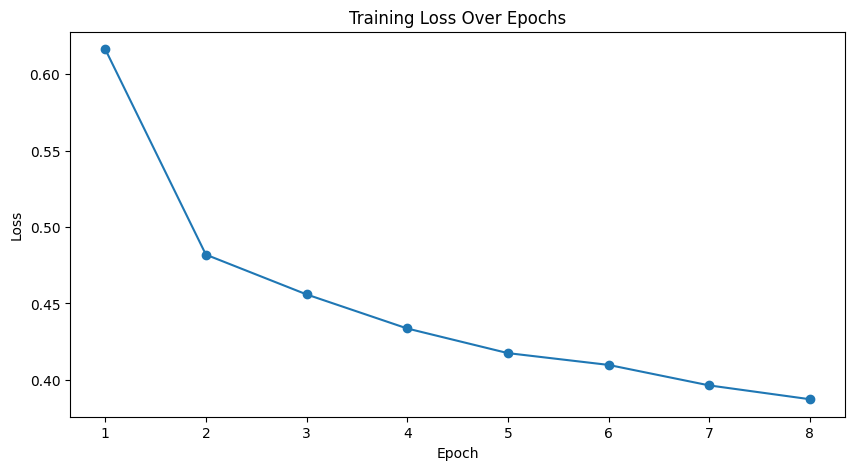

In [37]:
train_losses, stopped_early = train_with_anomaly_detection(model, train_loader, optimizer, device, 8)

**Function to rerun Training model Cell after you interupt the execution (stop half way). Dont use unless needed**

In [36]:

import gc


def clear_gpu_memory():
    """Completely clears GPU memory and resets CUDA state"""
    # Clear PyTorch cache
    torch.cuda.empty_cache()

    # Force garbage collection
    gc.collect()

    # Reset GPU memory stats
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

    # Set environment variables to prevent fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    print("GPU memory cleared and CUDA state reset")

GPU memory cleared and CUDA state reset


# Save the CheckPoint afterwards

In [39]:
import torch
from datetime import datetime

# Get current timestamp
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Format: YYYY-MM-DD_HH-MM-SS

# Save model checkpoint with timestamp
###################CHANGE TO YOUR MODEL NAME##############################

checkpoint_filename = f"{current_time}_fasterrcnn_epoch_{num_epochs+1}.pth"

###################CHANGE TO YOUR MODEL NAME##############################

torch.save(model.state_dict(), checkpoint_filename)

print(f"Model saved as {checkpoint_filename}")


Model saved as 2025-04-06_06-08-02_fasterrcnn_epoch_9.pth


# 4. Load the Model and Evaluate

In [40]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)  # No default weights
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the saved weights
###################CHANGE TO YOUR CHECKPOINT PATH THAT YOU SAVED / UPLOADED##############################

checkpoint_path = "/content/2025-04-06_06-08-02_fasterrcnn_epoch_9.pth"  # Update with your checkpoint file name

###################CHANGE TO YOUR CHECKPOINT PATH THAT YOU SAVED / UPLOADED##############################

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Model loaded successfully!


In [ ]:
!pip install torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torchmetrics.detection import MeanAveragePrecision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

# 5. Evaluating Model + Visualizing the Results

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.patches as patches
from torchvision.ops import box_iou
from tqdm import tqdm

# Function to calculate mAP
def calculate_map(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    """
    Calculate mean Average Precision for object detection
    """
    # Initialize precision and recall values for each class
    average_precisions = {}

    # Process each class
    for c in range(1, num_classes):  # Skip background class (0)
        # Get predictions and ground truths for this class
        class_pred_indices = (pred_labels == c).nonzero(as_tuple=True)[0]
        class_gt_indices = (gt_labels == c).nonzero(as_tuple=True)[0]

        if len(class_gt_indices) == 0:
            continue

        # If no predictions for this class, AP = 0
        if len(class_pred_indices) == 0:
            average_precisions[c] = 0
            continue

        # Get the predictions for this class
        class_pred_boxes = pred_boxes[class_pred_indices]
        class_pred_scores = pred_scores[class_pred_indices]

        # Sort predictions by score
        score_sorted_indices = torch.argsort(class_pred_scores, descending=True)
        class_pred_boxes = class_pred_boxes[score_sorted_indices]
        class_pred_scores = class_pred_scores[score_sorted_indices]

        # Get ground truth for this class
        class_gt_boxes = gt_boxes[class_gt_indices]

        # Calculate IoU between predictions and ground truth
        ious = box_iou(class_pred_boxes, class_gt_boxes)

        # Initialize variables for precision-recall calculation
        tp = torch.zeros(len(class_pred_boxes))
        fp = torch.zeros(len(class_pred_boxes))
        gt_matched = torch.zeros(len(class_gt_boxes))

        # For each prediction
        for pred_idx in range(len(class_pred_boxes)):
            # Find the best matching ground truth
            max_iou, max_idx = torch.max(ious[pred_idx], dim=0)

            # If IoU exceeds threshold and the ground truth hasn't been matched
            if max_iou >= iou_threshold and gt_matched[max_idx] == 0:
                tp[pred_idx] = 1
                gt_matched[max_idx] = 1
            else:
                fp[pred_idx] = 1

        # Calculate cumulative precision and recall
        cumulative_tp = torch.cumsum(tp, dim=0)
        cumulative_fp = torch.cumsum(fp, dim=0)
        precision = cumulative_tp / (cumulative_tp + cumulative_fp)
        recall = cumulative_tp / len(class_gt_boxes)

        # Calculate AP using 11-point interpolation
        ap = 0.0
        for t in np.arange(0.0, 1.1, 0.1):
            if torch.sum(recall >= t) == 0:
                p = 0
            else:
                p = torch.max(precision[recall >= t])
            ap += p / 11.0

        average_precisions[c] = ap.item()

    # Calculate mAP
    if len(average_precisions) > 0:
        mAP = sum(average_precisions.values()) / len(average_precisions)
    else:
        mAP = 0.0

    return mAP, average_precisions

# Function to visualize predictions
def visualize_predictions(image, pred_boxes, pred_labels, pred_scores, gt_boxes=None, gt_labels=None, score_threshold=0.5):
    """
    Visualize predictions and ground truth boxes on the image
    """
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Define colors for different classes (can be extended for more classes)
    colors = ['r', 'g', 'b', 'c', 'm', 'y']

    # Draw predicted boxes
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score < score_threshold:
            continue

        x1, y1, x2, y2 = box.cpu().numpy()
        width = x2 - x1
        height = y2 - y1

        # Create rectangle patch
        color_idx = (label.item() - 1) % len(colors)
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                 edgecolor=colors[color_idx], facecolor='none')
        ax.add_patch(rect)

        # Add label and score
        plt.text(x1, y1, f'Class {label.item()}: {score.item():.2f}',
                 fontsize=10, bbox=dict(facecolor=colors[color_idx], alpha=0.5))

    # Draw ground truth boxes if provided
    if gt_boxes is not None and gt_labels is not None:
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box.cpu().numpy()
            width = x2 - x1
            height = y2 - y1

            # Create rectangle patch with dashed line
            color_idx = (label.item() - 1) % len(colors)
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                   edgecolor=colors[color_idx], facecolor='none', linestyle='--')
            ax.add_patch(rect)

            # Add ground truth label
            plt.text(x1, y1-15, f'GT Class {label.item()}',
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    return fig

# Function to evaluate model on test dataset
def evaluate_model(model, data_loader, device):
    model.eval()

    all_pred_boxes = []
    all_pred_labels = []
    all_pred_scores = []
    all_gt_boxes = []
    all_gt_labels = []
    all_images = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = list(img.to(device) for img in images)

            # Get predictions
            outputs = model(images)

            # Store predictions and ground truth
            for i, output in enumerate(outputs):
                all_pred_boxes.append(output['boxes'])
                all_pred_labels.append(output['labels'])
                all_pred_scores.append(output['scores'])
                all_gt_boxes.append(targets[i]['boxes'].to(device))
                all_gt_labels.append(targets[i]['labels'].to(device))
                all_images.append(images[i])

    return all_pred_boxes, all_pred_labels, all_pred_scores, all_gt_boxes, all_gt_labels, all_images

# Precision-Recall Curve
def plot_precision_recall_curve(precisions, recalls, class_id):
    plt.figure(figsize=(10, 7))
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Class {class_id}')
    plt.grid(True)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    return plt.gcf()

# Plot mAP at different IoU thresholds
def plot_map_at_iou_thresholds(model, data_loader, device):
    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    maps = []

    all_pred_boxes, all_pred_labels, all_pred_scores, all_gt_boxes, all_gt_labels, _ = evaluate_model(model, data_loader, device)

    for iou_threshold in iou_thresholds:
        mAPs = []
        for i in range(len(all_pred_boxes)):
            mAP, _ = calculate_map(
                all_pred_boxes[i], all_pred_labels[i], all_pred_scores[i],
                all_gt_boxes[i], all_gt_labels[i], iou_threshold=iou_threshold
            )
            mAPs.append(mAP)

        avg_mAP = sum(mAPs) / len(mAPs) if mAPs else 0
        maps.append(avg_mAP)

    plt.figure(figsize=(10, 7))
    plt.plot(iou_thresholds, maps, 'b-o', linewidth=2)
    plt.xlabel('IoU Threshold')
    plt.ylabel('mAP')
    plt.title('mAP at different IoU thresholds')
    plt.grid(True)
    plt.ylim([0.0, 1.05])

    return plt.gcf()

# Confusion matrix for classification accuracy
def plot_confusion_matrix(pred_labels, gt_labels, num_classes):
    # Flatten all labels
    pred_labels_flat = torch.cat([labels for labels in pred_labels])
    gt_labels_flat = torch.cat([labels for labels in gt_labels])

    # Create confusion matrix
    conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for p, t in zip(pred_labels_flat, gt_labels_flat):
        conf_matrix[t.item(), p.item()] += 1

    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = range(num_classes)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j].item(), 'd'),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    return plt.gcf()

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Average mAP@0.5: 0.8661
Class 1 AP: 0.8371
Class 2 AP: 0.8130
Class 3 AP: 0.8935
Class 4 AP: 0.9721
Class 5 AP: 0.8750
Class 6 AP: 0.8547
Class 7 AP: 0.8124
Class 8 AP: 0.8315


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Evaluation completed. All visualizations saved.


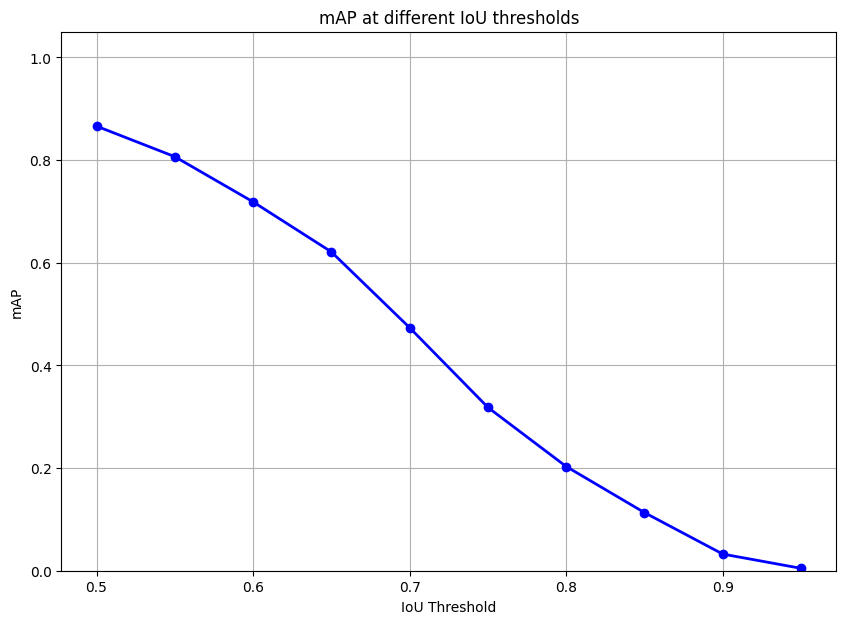

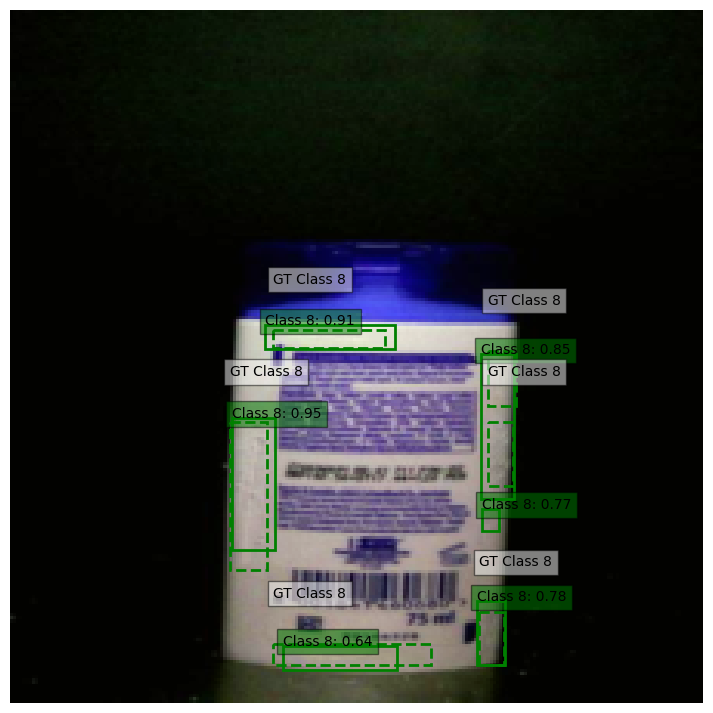

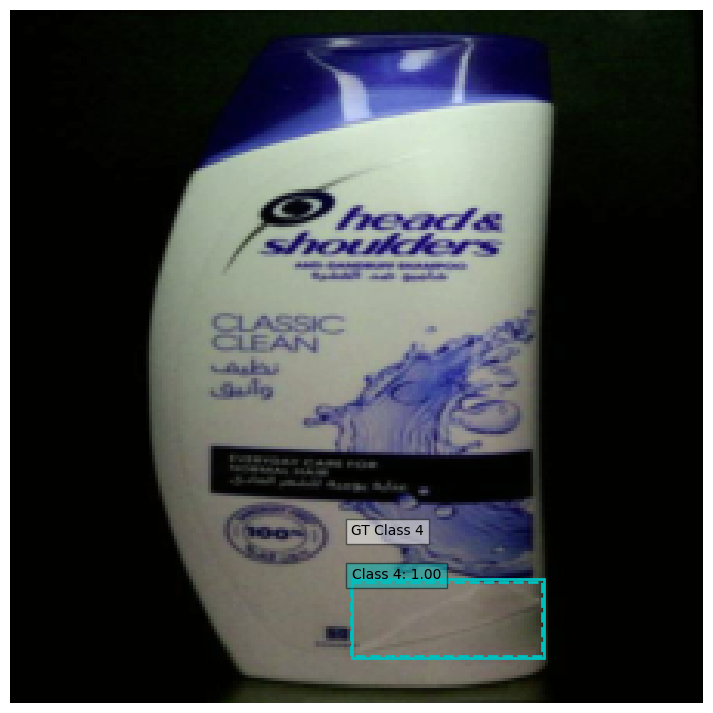

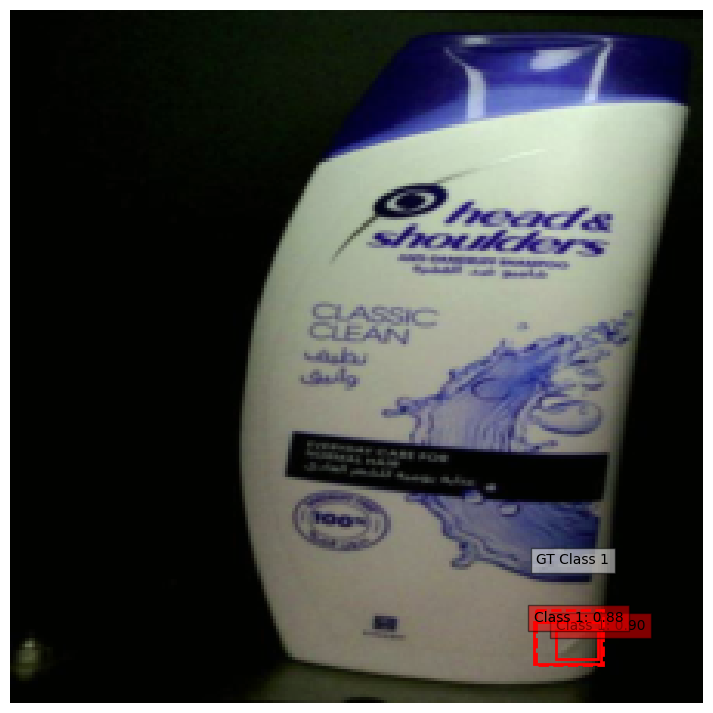

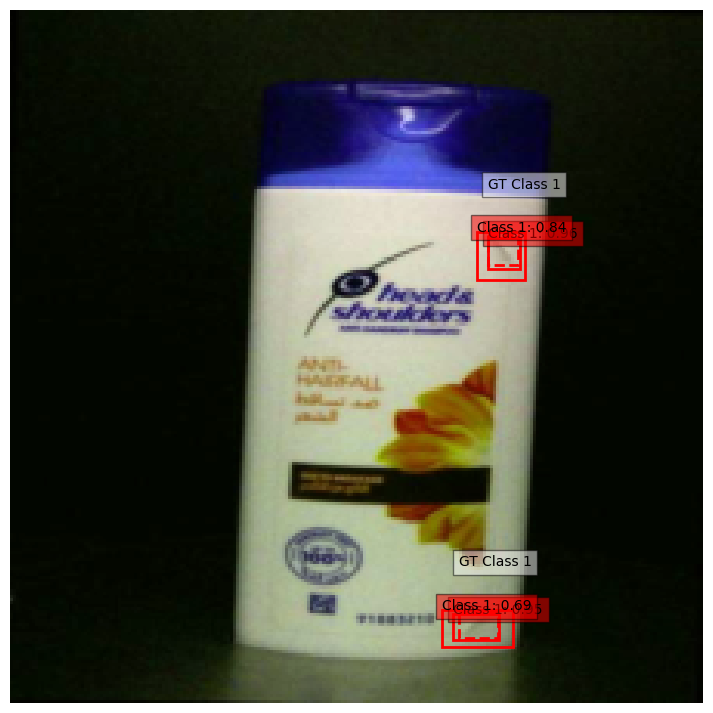

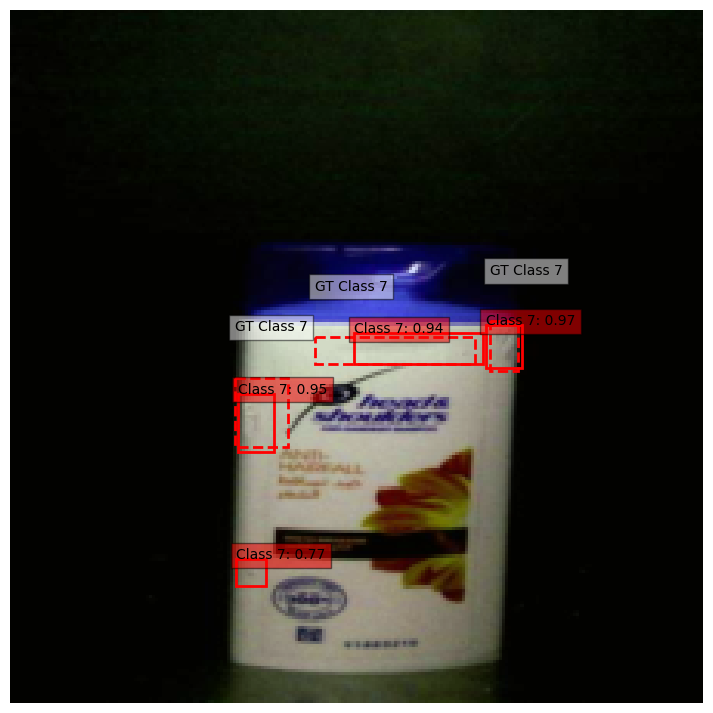

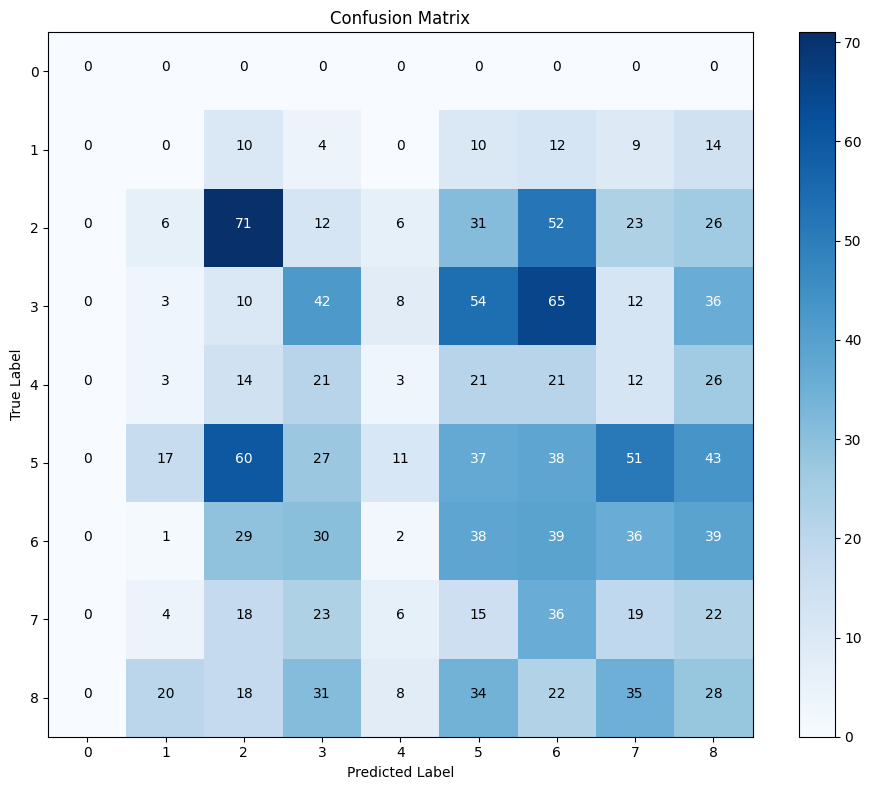

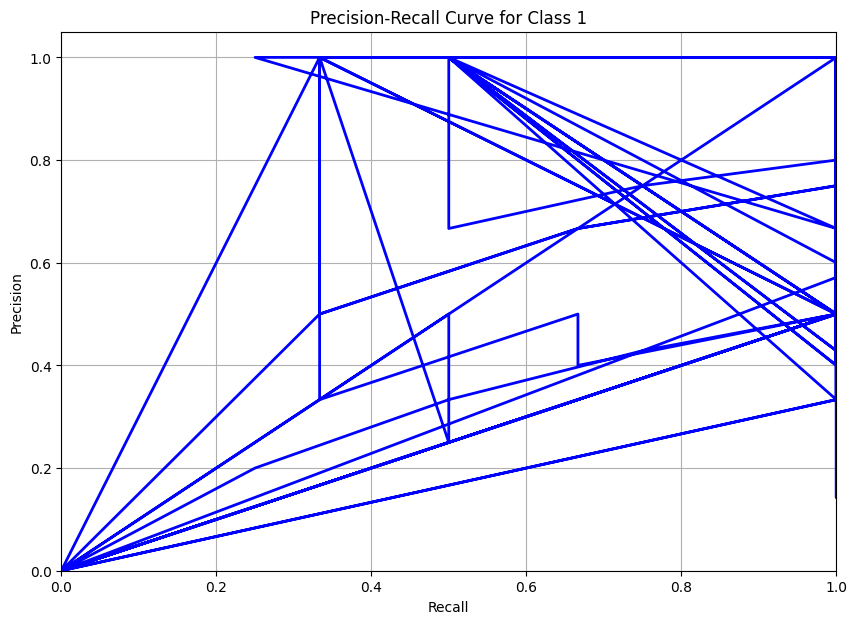

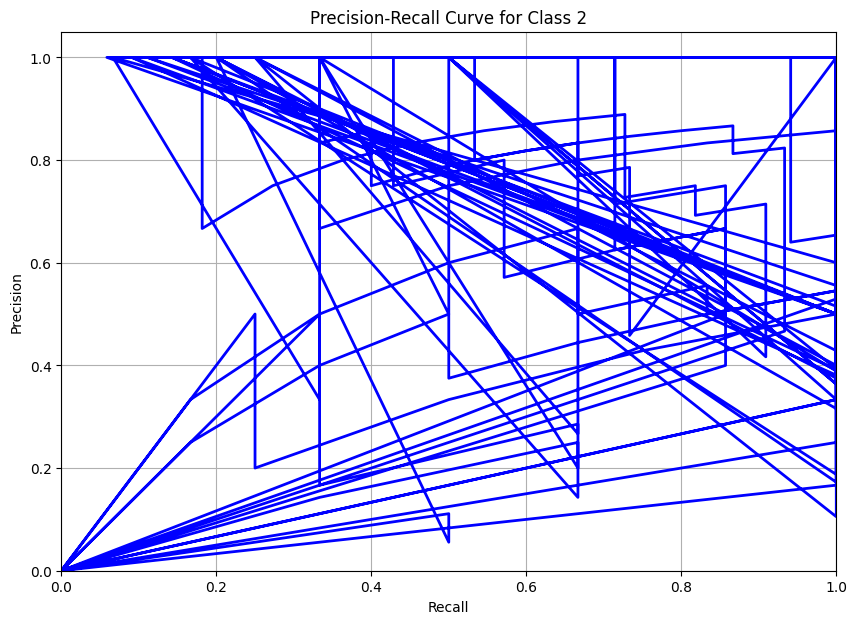

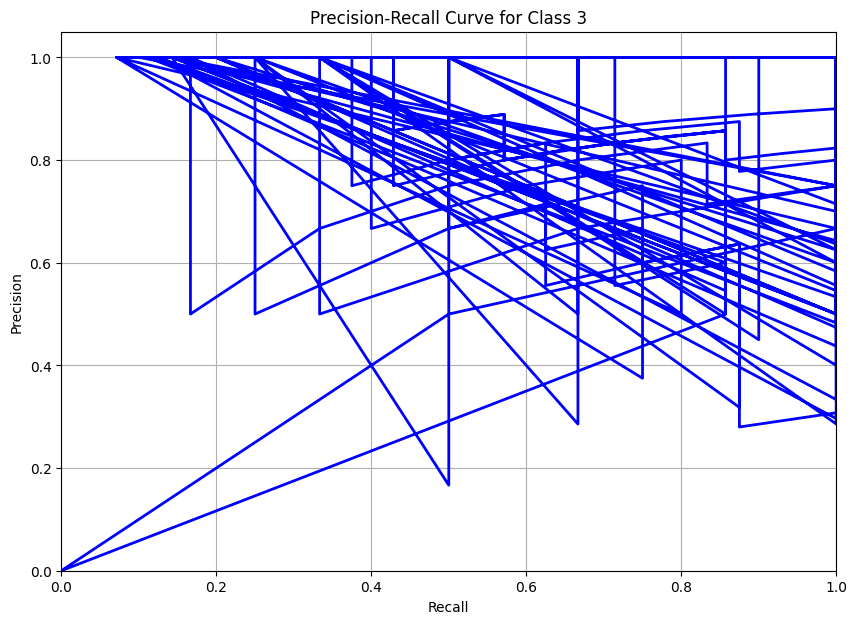

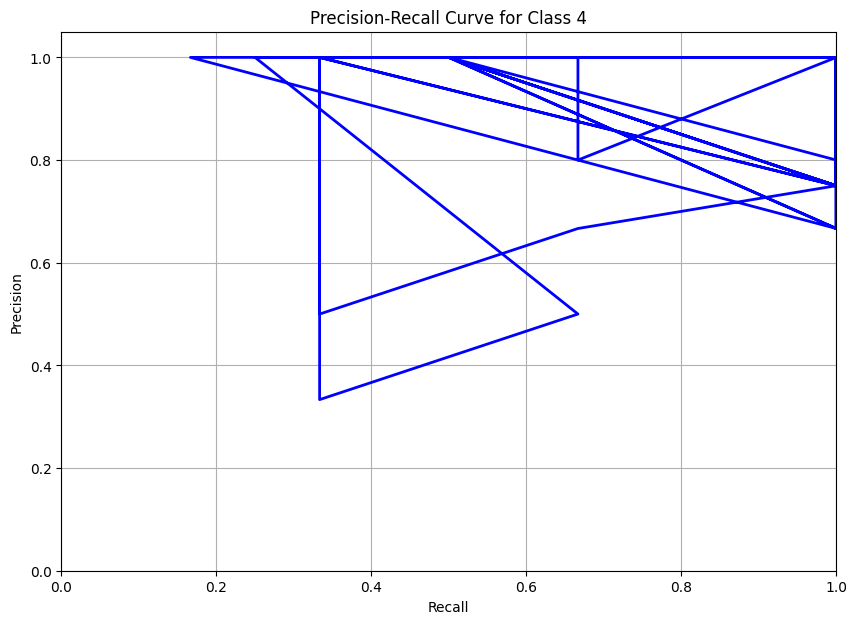

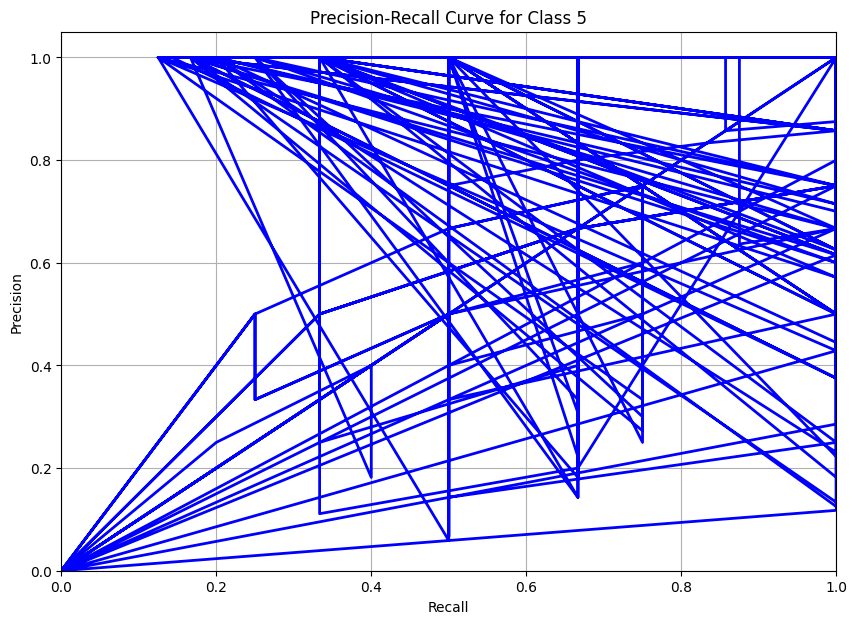

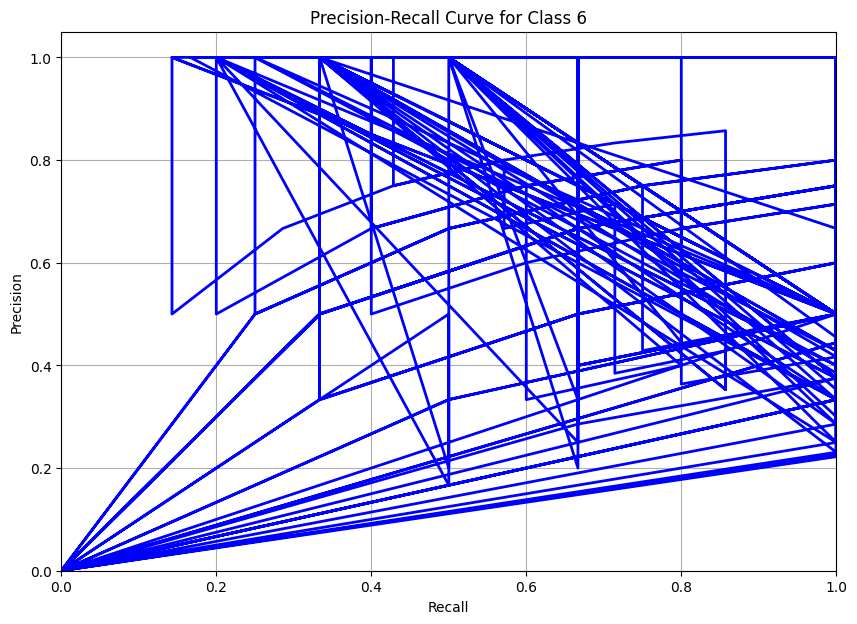

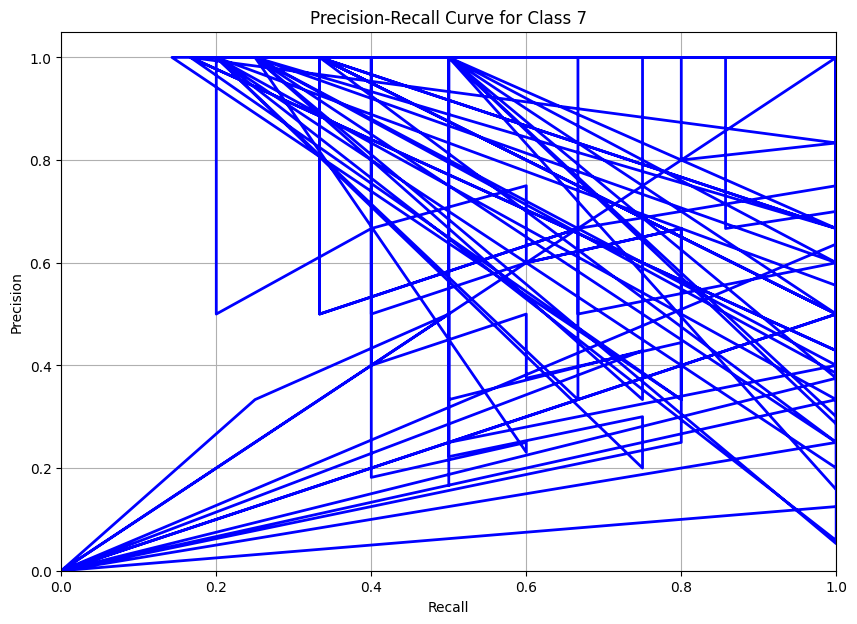

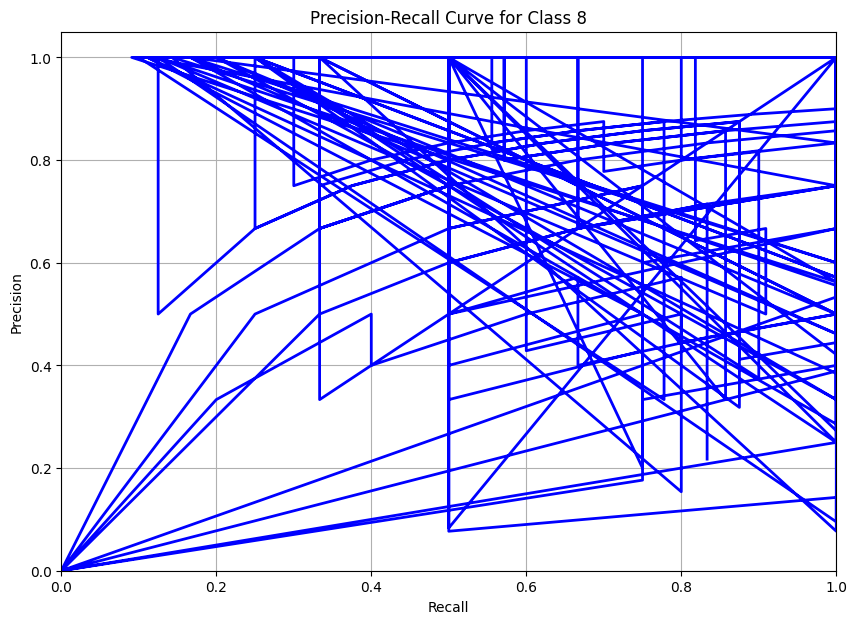

In [ ]:
# Main evaluation script
def run_evaluation():

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Run evaluation
    all_pred_boxes, all_pred_labels, all_pred_scores, all_gt_boxes, all_gt_labels, all_images = evaluate_model(model, test_loader, device)

    # Calculate overall mAP at IoU=0.5
    mAPs = []
    for i in range(len(all_pred_boxes)):
        mAP, ap_per_class = calculate_map(
            all_pred_boxes[i], all_pred_labels[i], all_pred_scores[i],
            all_gt_boxes[i], all_gt_labels[i]
        )
        mAPs.append(mAP)

    avg_mAP = sum(mAPs) / len(mAPs) if mAPs else 0
    print(f"Average mAP@0.5: {avg_mAP:.4f}")

    # Print AP for each class
    class_aps = {}
    for c in range(1, num_classes):
        class_aps[c] = []

    for i in range(len(all_pred_boxes)):
        _, ap_per_class = calculate_map(
            all_pred_boxes[i], all_pred_labels[i], all_pred_scores[i],
            all_gt_boxes[i], all_gt_labels[i]
        )
        for c, ap in ap_per_class.items():
            class_aps[c].append(ap)

    for c in range(1, num_classes):
        if class_aps[c]:
            avg_ap = sum(class_aps[c]) / len(class_aps[c])
            print(f"Class {c} AP: {avg_ap:.4f}")

    # Generate visualizations

    # 1. Plot mAP at different IoU thresholds
    map_iou_fig = plot_map_at_iou_thresholds(model, test_loader, device)
    map_iou_fig.savefig('map_iou_thresholds.png')

    # 2. Visualize predictions on sample images
    for i in range(min(5, len(all_images))):  # Visualize first 5 images
        # Convert tensor to PIL image for visualization
        image = all_images[i].permute(1, 2, 0).cpu().numpy()

        # Normalize image for display
        image = (image - image.min()) / (image.max() - image.min())

        fig = visualize_predictions(
            image,
            all_pred_boxes[i], all_pred_labels[i], all_pred_scores[i],
            all_gt_boxes[i], all_gt_labels[i]
        )
        fig.savefig(f'prediction_visualization_{i}.png')

    # 3. Confusion Matrix
    conf_matrix_fig = plot_confusion_matrix(all_pred_labels, all_gt_labels, num_classes)
    conf_matrix_fig.savefig('confusion_matrix.png')

    # 4. Precision-Recall curve for each class
    for c in range(1, num_classes):
        # Collect precision and recall values for this class across all images
        all_precisions = []
        all_recalls = []

        for i in range(len(all_pred_boxes)):
            # Filter predictions for this class
            class_pred_indices = (all_pred_labels[i] == c).nonzero(as_tuple=True)[0]
            class_gt_indices = (all_gt_labels[i] == c).nonzero(as_tuple=True)[0]

            if len(class_gt_indices) == 0:
                continue

            if len(class_pred_indices) == 0:
                continue

            # Get predictions for this class
            class_pred_boxes = all_pred_boxes[i][class_pred_indices]
            class_pred_scores = all_pred_scores[i][class_pred_indices]

            # Sort by score
            score_sorted_indices = torch.argsort(class_pred_scores, descending=True)
            class_pred_boxes = class_pred_boxes[score_sorted_indices]
            class_pred_scores = class_pred_scores[score_sorted_indices]

            # Get ground truth for this class
            class_gt_boxes = all_gt_boxes[i][class_gt_indices]

            # Calculate IoU
            ious = box_iou(class_pred_boxes, class_gt_boxes)

            # Calculate precision and recall
            tp = torch.zeros(len(class_pred_boxes))
            fp = torch.zeros(len(class_pred_boxes))
            gt_matched = torch.zeros(len(class_gt_boxes))

            for pred_idx in range(len(class_pred_boxes)):
                max_iou, max_idx = torch.max(ious[pred_idx], dim=0)

                if max_iou >= 0.5 and gt_matched[max_idx] == 0:
                    tp[pred_idx] = 1
                    gt_matched[max_idx] = 1
                else:
                    fp[pred_idx] = 1

            cumulative_tp = torch.cumsum(tp, dim=0)
            cumulative_fp = torch.cumsum(fp, dim=0)
            precision = cumulative_tp / (cumulative_tp + cumulative_fp)
            recall = cumulative_tp / len(class_gt_boxes)

            all_precisions.append(precision)
            all_recalls.append(recall)

        if all_precisions and all_recalls:
            # Concatenate all precision and recall values
            all_precisions_cat = torch.cat(all_precisions)
            all_recalls_cat = torch.cat(all_recalls)

            # Plot precision-recall curve
            pr_curve_fig = plot_precision_recall_curve(all_precisions_cat, all_recalls_cat, c)
            pr_curve_fig.savefig(f'precision_recall_class_{c}.png')

    print("Evaluation completed. All visualizations saved.")

# Call the main evaluation function
if __name__ == "__main__":
    run_evaluation()